In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as ss

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-bogdanov/ab-test_final_project.csv", sep=";")

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.shape

(404770, 3)

In [5]:
# присутствуют чистые данные - отсутствуют пустые значения
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
# одна строка данных на каждого пользователя
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [7]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [9]:
# подтверждается условие о малом количестве платящих пользователей
df.describe()["revenue"]

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [10]:
# определим какая группа является тестовой, а какая контрольной
df.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Группа "a" - контрольная, "b" соответственно тестовая, ARPU в группе "b" по условию выше на 5%. Подметим, что группы примерно равны!

# 1. Сформируем фреймы данных для иллюстрации некоторых ключевых показателей и метрик

In [11]:
key_indicators_df = df.groupby('testgroup', as_index=False).agg(
                    users = ('user_id', 'count'),
                    paying_users = ('revenue', lambda user: (user > 0).sum()),
                    revenue_sum = ('revenue','sum'),
                    revenue_mean = ("revenue", "mean"),
                    revenue_median = ("revenue", "median"),
                    revenue_min = ("revenue", "min"),
                    revenue_max = ("revenue", "max")
                )

In [12]:
key_indicators_df

,testgroup,users,paying_users,revenue_sum,revenue_mean,revenue_median,revenue_min,revenue_max
0,a,202103,1928,5136189,25.413720,0,0,37433
1,b,202667,1805,5421603,26.751287,0,0,4000


In [13]:
revenue_sum_a = df.query("testgroup == 'a'").revenue.sum()
revenue_sum_b = df.query("testgroup == 'b'").revenue.sum()

user_a = df.query("testgroup == 'a'").user_id.count()
user_b = df.query("testgroup == 'b'").user_id.count()

payment_users_a = df.query("testgroup == 'a' and revenue > 0").user_id.count()
payment_users_b = df.query("testgroup == 'b' and revenue > 0").user_id.count()

median_a = df.query("testgroup == 'a' and revenue > 0").revenue.median()
median_b = df.query("testgroup == 'b' and revenue > 0").revenue.median()
    
cr_a = round(payment_users_a / user_a * 100, 2)
cr_b = round(payment_users_b / user_b * 100, 2)
         
arpu_a = df.query("testgroup == 'a'").revenue.mean()
arpu_b = df.query("testgroup == 'b'").revenue.mean()

arppu_a = revenue_sum_a / payment_users_a
arppu_b = revenue_sum_b / payment_users_b

df_metrics = pd.DataFrame({
              'Clients': [payment_users_a, payment_users_b],
               'Median': [median_a, median_b],
              'CR': [cr_a, cr_b],
              'ARPU': [arpu_a, arpu_b],
              'ARPPU': [arppu_a, arppu_b]},
               index=['a', 'b'])

In [14]:
df_metrics

,Clients,Median,CR,ARPU,ARPPU
a,1928,311.0,0.95,25.413720,2663.998444
b,1805,3022.0,0.89,26.751287,3003.658172


# Вывод 1

Замечаем, что многие ключевые показатели и метрики отличаются между группами! Однако это замечание требует проверок на статистическую значимость, последующих далее.

# 2. Проверим, изменилось ли число платящих пользователей (CR)

In [15]:
df["is_paying"] = (df["revenue"] > 0).astype(int)

In [16]:
df

,user_id,revenue,testgroup,is_paying
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [17]:
pd.crosstab(df.testgroup, df.is_paying)

is_paying,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [18]:
exp, obs, stat = pg.chi2_independence(df, "testgroup", "is_paying")

In [19]:
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


# Вывод 2

Показатель p-value < 0.05, т.е. является статистическими значимым (если брать общепринятый уровень значимости и не повышать порог значимости, например до 0.01), что говорит о том, что количество платящих пользователей, что важно, в КОНТРОЛЬНОЙ группе, статистически больше, чем в тестовой по тесту хи-квадрат. С учетом того, что количество клиентов в обеих группах примерно одинаково!

In [20]:
# создадим отдельный датафрейм с платящими пользователями
df_not_null_revenue = df.query("revenue > 0")

In [21]:
df_not_null_revenue

,user_id,revenue,testgroup,is_paying
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1
...,...,...,...,...
404315,404316,262,a,1
404525,404526,3120,b,1
404543,404544,369,a,1
404602,404603,251,a,1


In [22]:
# Наблюдаем какой-то большой разрыв между 75 процентилем и максимальным значением - визуализируем наше распределение
df_not_null_revenue.describe()["revenue"]

count     3733.000000
mean      2828.232521
std       6516.770722
min        200.000000
25%        309.000000
50%       2052.000000
75%       3126.000000
max      37433.000000
Name: revenue, dtype: float64

# 3. Рассмотрим данные поконкретнее, проверим на наличие выбросов, попробуем дать интерпретацию при их наличии

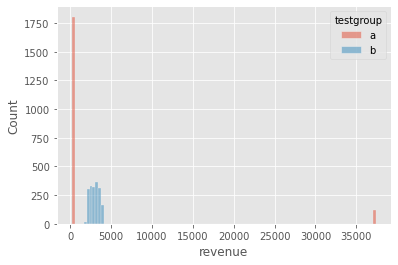

In [23]:
sns.histplot(data=df_not_null_revenue, x="revenue", hue="testgroup")

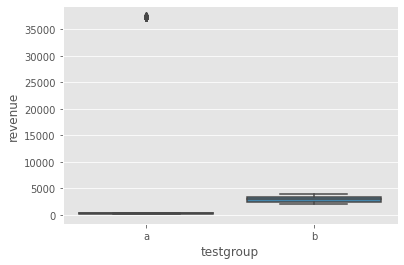

In [24]:
sns.boxplot(data=df_not_null_revenue, x="testgroup", y="revenue")

Видим слой из наблюдений, где значения сильно отличаются от остальных - рассмотрим его повнимательней

In [25]:
df_not_null_revenue.query("revenue > 5000")

,user_id,revenue,testgroup,is_paying
416,417,37324,a,1
4428,4429,37304,a,1
5777,5778,37315,a,1
8065,8066,37307,a,1
8743,8744,37334,a,1
...,...,...,...,...
360696,360697,37347,a,1
378668,378669,37297,a,1
389341,389342,37298,a,1
394580,394581,37302,a,1


In [26]:
df_not_null_revenue.query("revenue > 5000").nunique()

user_id      123
revenue       67
testgroup      1
is_paying      1
dtype: int64

In [27]:
df_not_null_revenue.query("revenue > 5000").describe()["revenue"]

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [28]:
print("Сверхплатящие из контрольной группы: ", round((123/1928)*100, 2), "% всей группы")

Сверхплатящие из контрольной группы:  6.38 % всей группы


Слой состоит из 123 наблюдений, все из контрольной группы с медианой в 37311 со стандартным отклонением от среднего в 25 единиц.
Поскольку это всего 6% всей выборки платящих из данной группы, отфильтруем эти значения и посмотрим на данные

In [29]:
# сформируем фрейм из обычных пользователей (не относящихся к сегменту 'за 37 тысяч')
df_not_null_revenue_common = df_not_null_revenue.query("revenue < 5000")

In [30]:
df_not_null_revenue_common

,user_id,revenue,testgroup,is_paying
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1
...,...,...,...,...
404315,404316,262,a,1
404525,404526,3120,b,1
404543,404544,369,a,1
404602,404603,251,a,1


In [31]:
df_not_null_revenue_common.describe()["revenue"]

count    3610.000000
mean     1653.058172
std      1410.745760
min       200.000000
25%       305.250000
50%      1200.000000
75%      3021.500000
max      4000.000000
Name: revenue, dtype: float64

# Вывод 3

В контрольной группе выявлен так называемый сегмент пользователей 'за 37 тысяч', составляющий всего 6.38% всей группы. Именно эти покупки очень сильно сдвигают показатель среднего контрольной группы к тестовой. Требуется рассмотреть распределения групп как с этим сегментом, так и без него, после чего сформировать финальное решение по включению/исключению этих данных для проверки статистических гипотез.

# 4. Визуализируем полученные данные, посмотрим на распределения

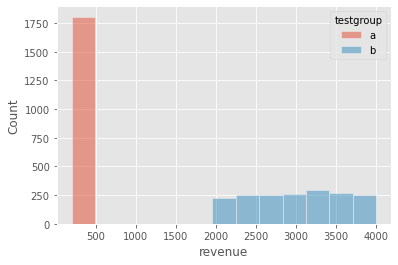

In [32]:
sns.histplot(data=df_not_null_revenue_common, x="revenue", hue="testgroup")

Посмотрим на показатели некоторых мер центральной тенденции с помощью графиков и проверим распределения на нормальность для последующих статистических тестов

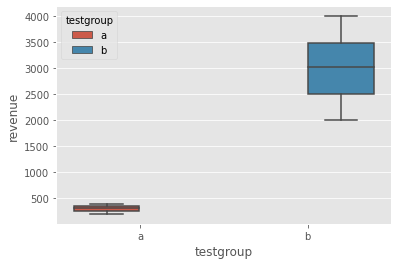

In [33]:
sns.boxplot(data=df_not_null_revenue_common, x="testgroup", y="revenue", hue="testgroup")

In [34]:
# разделим данные по группам, посмотрим на распределение
df_control_group = df_not_null_revenue_common.query("testgroup == 'a'")
df_test_group = df_not_null_revenue_common.query("testgroup == 'b'")

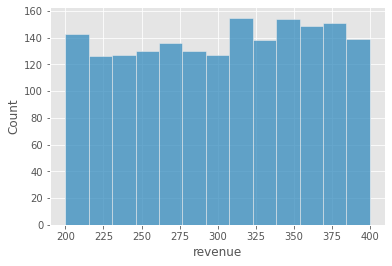

In [35]:
sns.histplot(data=df_control_group, x="revenue")

In [36]:
print("Размер группы:", df_control_group.shape[0])

Размер группы: 1805


In [37]:
print("Дисперсия:", df_control_group.revenue.var())

Дисперсия: 3354.059917941662


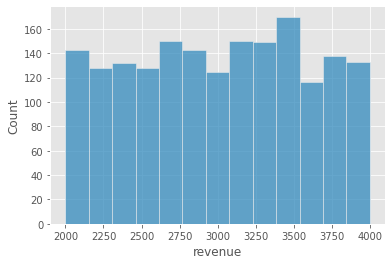

In [38]:
sns.histplot(data=df_test_group, x="revenue")

In [39]:
print("Размер группы:", df_test_group.shape[0])

Размер группы: 1805


In [40]:
print("Дисперсия:", df_test_group.revenue.var())

Дисперсия: 327893.33153656696


С виду полученный данные не распределены по закону Гаусса - проверим нашу гипотезу тестами

In [41]:
pg.normality(df_not_null_revenue_common, "revenue", "testgroup", "normaltest")

,W,pval,normal
a,1341.200992,5.779697e-292,False
b,1068.860008,7.943249e-233,False


In [42]:
ss.shapiro(df_control_group.revenue)

ShapiroResult(statistic=0.9546283483505249, pvalue=3.004845972000649e-23)

In [43]:
ss.shapiro(df_test_group.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

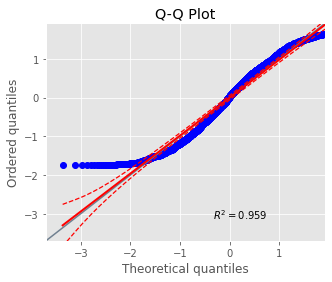

In [44]:
pg.qqplot(df_test_group.revenue, dist='norm')

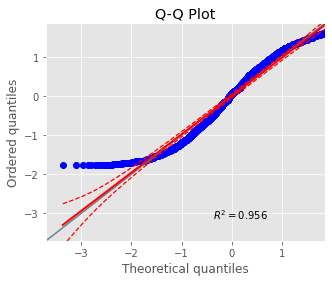

In [45]:
# без сегмента 'за 37 тысяч'
pg.qqplot(df_control_group.revenue, dist='norm')

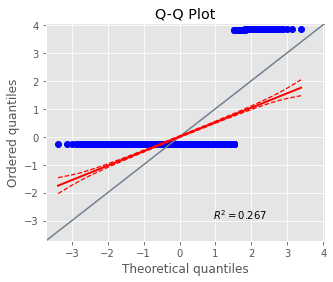

In [46]:
# с сегментом 'за 37 тысяч'
pg.qqplot(df_not_null_revenue.query("testgroup == 'a'").revenue, dist='norm')

# Важный вывод 4

При подробном рассмотрении данных в этом пункте, сложилось впечатление, что a/b тест был проведен некорректно (нарушилась система сплитования), основаное на наличии в контрольной группе сегмента за 37 тысяч. В первую очередь при возможности я бы проверил ее.  

Однако, если при моделировании все было сделано верно и учитывая, что акционные предложения присутствуют в обеих группах, просто в контрольной группе акционные предложения имели вот такие ценники (как дешевые, так и очень дорогие), а в тестовой предлагались другие акционные товары с другим диапазоном цен, то я останусь при мнении, что надо оставлять полные исходные данные (т.е. с сегментом за 37 тысяч), поскольку в противном случае при проведении статистических тестов могут быть полученны неверные результаты, что за собой последует неправильные для бизнеса решения. Также учтем, что нами был уже проведен статистический тест на CR на полном датасете и выявлена статистическая значимость, поэтому и оставшиеся метрики стоит оценивать в разрезе этого набора.

Также графически и с помощью тестов было получено, что распределение в полученных выборках не является равномерным. Это важное замечание будет учтено при проверки последующих статистических гипотез о различии ARPU и ARPPU!

# 5 Теоретический пункт - выбор статистического критерия для анализа ARPU и ARPPU

Для проверки этих двух важных метрик выберем один, наиболее подходящий статистический метод, поскольку практика проверки результатов одного критерия другим является неудачной и может повлечь ошибки.

Тесты Стьюдента и Манна-Уитни являются популярными методами проверки гипотез о разнице в средних для различных метрик, включая ARPU и ARPPU. Однако эти тесты имеют некоторые недостатки, которые следует учитывать при их применении. А именно:

1. Предположение о нормальности: Тест Стьюдента основан на предположении о том, что выборки следуют нормальному распределению. Если это предположение нарушается, то результаты теста могут быть ненадежными. Тест Манна-Уитни менее чувствителен к нарушению нормальности, но все же может терять мощность при сильно ненормальных данных.


2. Равенство дисперсий: Тест Стьюдента предполагает, что дисперсии в сравниваемых выборках равны. Если это предположение не выполняется, то результаты теста могут быть искажены. Тест Манна-Уитни не требует равенства дисперсий, но может быть менее мощным, когда дисперсии значительно отличаются.


3. Неспособность учесть структуру данных: Тесты Стьюдента и Манна-Уитни не учитывают структуру данных, такую как кластеризация или зависимость наблюдений. Это может привести к неверным выводам, если структура данных не учитывается при проведении теста.


4. Касательно теста Манна-Уитни. Важно отметить, что этот критерий не сравнивает средние. Наиболее частая его интерпретация - он проверяет, что вероятность случайно взять из первой выборки более высокое значение, чем из второй, равна 50%. Поэтому для нашего случая, когда у нас есть акционные предложения с абсолютно разным диапазоном цен, этот критерией не является подходящим.

Оценивая все эти пункты и основывясь на ранее приведенном анализе полученных данных, делаем вывод, что эти два критерия нам не подходят, поскольку у нас присутствуют ненормальность распределения, различия в дисперсиях и так далее.

В нашем случае одной из хороших практик будет применение метода bootstrap. Для его проведения не требуется учет вышеописанных оговорок и в целом, бутстрап-метод предоставляет более гибкий и мощный подход для проверки гипотез о разнице в средних по сравнению с традиционными тестами Стьюдента и Манна-Уитни. Это позволяет получать более надежные результаты и делать более обоснованные выводы о данных.

# Вывод 5

Была приведена основательная база причины выбора статистического критерия bootstrap как основного для формирования итоговых выводов по проведенному a/b тесту.

# 6 Bootstrap как основной статистический тест для анализа

Bootstrap - это статистическая методика, которая используется для оценки точности статистических оценок путем повторного выборки из исходной выборки с заменой. Он позволяет не учитывать нормальное распределение и различие в дисперсиях, что для нас в данном случае полезно. Только сделаем поправку, что будем считать при каждом тест нашу выборку репрезентативно отражающей генеральную совокупность. Воспользуемся написанной функцией с дополнительного вебинара Анатолия Карпова, что представлена ниже:

https://www.youtube.com/watch?v=-zps6hm0nX8&t=3278s

In [53]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Гипотезы H0 - ARPU или ARPPU в контрольной группе статистически значимо не отличаются от этой же метрики в тестовой.

Гипотезы H1 - ARPU или ARPPU в контрольной группе статистически значимо отличаются от этой же метрики в тестовой.

Посмотрим на показатель **ARPU**

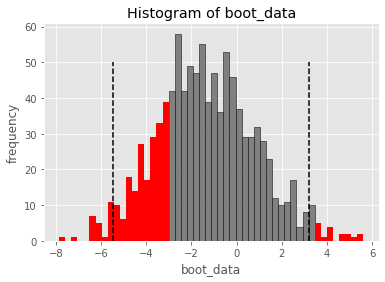

In [54]:
bootstrap_ARPU = get_bootstrap(df.query("testgroup == 'a'").revenue, df.query("testgroup == 'b'").revenue, boot_it=1000, statistic=np.mean)

In [55]:
bootstrap_ARPU["p_value"]

0.5409575034270431

P-value (0.54) больше порога статистической значимости (0.05) - отклонить H0 мы не можем, делаем вывод о том, что различие ARPU между представленными контрольной и тестовой группами **не является статистически значимым**.

Посмотрим на показатель **ARPPU**

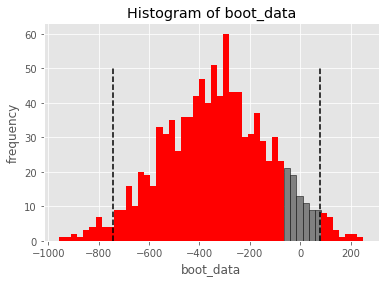

In [56]:
bootstrap_ARPPU_main = get_bootstrap(df_not_null_revenue.query("testgroup == 'a'").revenue, df_not_null_revenue.query("testgroup == 'b'").revenue, boot_it=1000, statistic=np.mean)

In [57]:
bootstrap_ARPPU_main["p_value"]

0.11392652519183999

P-value (0.11) больше порога статистической значимости (0.05) - отклонить H0 мы не можем, делаем вывод о том, что различие ARPPU между представленными контрольной и тестовой группами **не является статистически значимым**.

# Вывод 6

В метриках ARPU и ARPPU не было обнаружено статистически значимой разницы в средних, что в купе с конверсией и ранее описанным анализом плавно подводит нас к финальным выводам и ответу на главный вопрос.

# Заключение

Резюмируя весь вышеописанный анализ, тезисно можно сказать следующее:
1. По предложенным изначальным метрикам и показателям группы смотрелись примерно равно, тестовая была чуть лучше. Основываясь на последующем анализе можно сказать, что это было связано просто с большим диапазоном цен, другим набором предложений.


2. Число платящих пользователей или конверсия CR статистически выше у контрольной группы.


3. На данном этапе выявлен контингент 'за 37 тысяч', который составлял всего 6 процентов платящей аудитории и сильно сравнивал показатели между группами. На деле равенства никакого нет. Было принято решение о том, что требуется рассмотреть распределения групп как с этим сегментом, так и без него, после чего сформировать финальное решение по включению/исключению этих данных для проверки статистических гипотез


4. С помощью тестов и графически показано отсутсвие нормального распределения в данных. Также с учетом правильности сплитования (в реальной рабочей ситуации требует проверки), решено оставить полные исходные данные (т.е. с сегментом за 37 тысяч), поскольку в противном случае при проведении статистических тестов могут быть полученны неверные результаты, что за собой последует неправильные для бизнеса решения.


5. Была приведена основательная база причины выбора статистического критерия bootstrap как основного для формирования итоговых выводов по проведенному a/b тесту.


6. В метриках ARPU и ARPPU не было обнаружено статистически значимой разницы в средних, что в купе с конверсией и ранее описанным анализом плавно подводит нас к финальным выводам и ответу на главный вопрос.

**Ответ на главный вопрос:**


Следует ли раскатывать экспериментальный вариант акционных предложений на всех? Основываясь на метриках CR, ARPU, ARPPU и статистических методах хи-квадрат и бутстрап соответственно, при выявленно статистической значимости у конверсии, при том в пользу контрольной группы мой ответ **не стоит**. Для этого слишком мало оснований, причем оставшиеся не в пользу тестовой группы, требуются дальнейшие исследования.